<a href="https://colab.research.google.com/github/jieunjeon/Data-Science-Fundamental/blob/master/Exploration/%5BE_07%5D_Sentiment_Analysis_Movie_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis - Naver Moview Review Text

Goal of this project: 
1. Perform sentiment analysis based on  Naver sentiment movie corpus (https://github.com/e9t/nsmc) (in Korean)
2. Implement IMDB dataset loader function `imdb.data_loader()` to handle raw `nsmc dataset`.
3. `data_loader()` should handle...
  - Remove duplication of data
  - Remove missing NaN values
  - Tokenization with Korean Tokenizer
  - Remove Stopwords
  - Dictionary `word_to_index` configuration
  - Convert text string to dictionary index string
  - Returns `X_train, y_train, X_test, y_test, word_to_index`
4. Data PreProcessing
- Distribution of sentence length within the dataset
- Specify an Appropriate Maximum Sentence Length
- Add padding using keras.preprocessing.sequence.pad_sequences

## Table of Contents
1. Load the Data 
2. Data loader configuration
3. Preprocessing
4. Create Model and Validation dataset
5. Train the Model
6. Visualize Loss, and Accuracy
7. Analyze the trained Embedding layer
8. Utilize pre-trained Korean `Word2Vec` Embedding to improve the model.


# 1. Load the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path = '/content/drive/MyDrive/aiffel/EXP_7_data/'

In [3]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 19.2 MB/s 
     |████████████████████████████████| 86 kB 5.8 MB/s 
     |████████████████████████████████| 448 kB 44.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


We need to install `Mecab()` manually since it is not supported on Windows machine.

In [4]:
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

+ pip install konlpy
+ bash -x
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb-release /etc/os-release
+ '[' '/etc/lsb-release:DISTRIB_ID=Ubuntu
/etc/lsb-release:DISTRIB_DESCRIPTION="Ubuntu 18.04.5 LTS"
/etc/os-release:NAME="Ubuntu"
/etc/os-release:ID=ubuntu
/etc/os-release:ID_LIKE=debian
/etc/os-release:PRETTY_NAME="Ubuntu 18.04.5 LTS"
/etc/os-release:HOME_URL="https://www.ubuntu.com/"
/etc/os-release:SUPPORT_URL="https://help.ubuntu.com/"
/etc/os-release:BUG_REPORT_URL="https://bugs.launchpad.net/ubu

In [23]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from konlpy.tag import Mecab
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

from tensorflow.keras.callbacks import EarlyStopping
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.models import load_model

train_data = pd.read_table(data_path + 'ratings_train.txt')
test_data = pd.read_table(data_path + 'ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 2. Data loader configuration
The `NSMC` dataset is consisted with a completely raw text file, so let's create our own `data_loader()`

`data_loader()` should handle...
1. Remove duplication of data
2. Remove missing NaN values
3. Tokenization with Korean Tokenizer
4. Remove Stopwords
5. Dictionary word_to_index configuration
6. Convert text string to dictionary index string
7. Returns X_train, y_train, X_test, y_test, word_to_index

In [6]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [7]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    

In [8]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 3. Preprocessing
1. Check the distribution of length of the sentence within the dataset
2. Specify an Appropriate Maximum Sentence Length
3. Add padding using `keras.preprocessing.sequence.pad_sequences`

Let's see the distribution first

In [11]:
print(X_train[0])  # 1번째 리뷰데이터
print('label: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('first review - length: ', len(X_train[0]))
print('second review - length: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
label:  0
first review - length:  10
second review - length:  17


In [12]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('length - mean : ', np.mean(num_tokens))
print('length - max : ', np.max(num_tokens))
print('length - std. dev. : ', np.std(num_tokens))

length - mean :  15.969376315021577
length - max :  116
length - std. dev. :  12.843535456326455


Then let's specify an Appropriate Maximum Sentence Length

In [13]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('The total sentence of {}% will be included within the maxlen. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
The total sentence of 0.9342988343341575% will be included within the maxlen. 


Let's add padding using `keras.preprocessing.sequence.pad_sequences`

In [14]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [15]:
print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


## Validation dataset
Let's separate Train & Validation dataset. I will create 30000 validation set.

In [16]:
# validation set 30000
x_val = X_train[:30000]   
y_val = y_train[:30000]

# others then validation set
partial_x_train = X_train[30000:]  
partial_y_train = y_train[30000:]

In [36]:
print(x_val.shape)
print(y_val.shape)

(30000, 41)
(30000,)


Okay, now let's create model.

# 4. Create Model and Train multiple models

## 1) 1D CNN (1-D Convolutional Neural Network)

In [27]:
vocab_size = 10000
word_vector_dim = 16

conv1d_model = keras.Sequential()
conv1d_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
conv1d_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
conv1d_model.add(keras.layers.MaxPooling1D(5))
conv1d_model.add(keras.layers.Conv1D(16, 7, activation='relu'))
conv1d_model.add(keras.layers.GlobalMaxPooling1D())
conv1d_model.add(keras.layers.Dense(128, activation='relu'))
conv1d_model.add(keras.layers.Dense(1, activation='sigmoid'))

In [29]:
conv1d_model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

### Train the Model

In [31]:
cnn1d_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
cnn1d_history = cnn1d_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 69s 19ms/step - loss: 0.3656 - accuracy: 0.8341 - val_loss: 0.3199 - val_accuracy: 0.8620
Epoch 2/10
3631/3631 [==============================] - 68s 19ms/step - loss: 0.2615 - accuracy: 0.8909 - val_loss: 0.3260 - val_accuracy: 0.8590
Epoch 3/10
3631/3631 [==============================] - 67s 18ms/step - loss: 0.1811 - accuracy: 0.9284 - val_loss: 0.3699 - val_accuracy: 0.8580
Epoch 4/10
3631/3631 [==============================] - 67s 18ms/step - loss: 0.1172 - accuracy: 0.9552 - val_loss: 0.4856 - val_accuracy: 0.8517
Epoch 5/10
3631/3631 [==============================] - 67s 18ms/step - loss: 0.0806 - accuracy: 0.9690 - val_loss: 0.5886 - val_accuracy: 0.8481
Epoch 6/10
3631/3631 [==============================] - 67s 19ms/step - loss: 0.0610 - accuracy: 0.9768 - val_loss: 0.6544 - val_accuracy: 0.8456
Epoch 7/10
3631/3631 [==============================] - 68s 19ms/step - loss: 0.0480 - accuracy: 0.9817 - val_loss: 0.8756 -

In [36]:
results = cnn1d_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.0359 - accuracy: 0.8421
[1.035939335823059, 0.8421180844306946]


Okay, the accuracy is 0.8421!   
My goal 85%.

### Visualization

In [33]:
cnn1d_history_dict = cnn1d_history.history

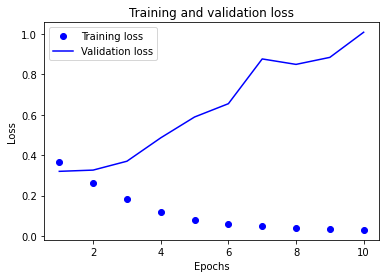

In [34]:
acc = cnn1d_history_dict['accuracy']
val_acc = cnn1d_history_dict['val_accuracy']
loss = cnn1d_history_dict['loss']
val_loss = cnn1d_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

I can see `Training loss` is decreasing, bug `Validation loss` is increasing fastly.

Then Let's visualize the accuracy

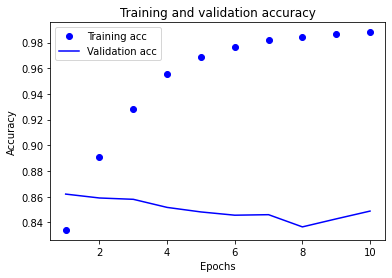

In [35]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

It's clearly saying that this model performance is not good enough.

### Embedding Layer
Let's try to add **word embedding** layer.

In [42]:
from collections import Counter
import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [37]:
embedding_layer = conv1d_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 64)


In [50]:
word2vec_file_path = data_path + 'ko.tsv'

In [40]:
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

vectors = conv1d_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [47]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['고마워요']
vector

array([-0.22506766, -0.29282412,  0.12613322, -0.37192607,  0.17950039,
       -0.32147697,  0.24564174, -0.2362066 ,  0.29055977,  0.21464482,
       -0.1553857 , -0.41177484,  0.20434754, -0.05985472,  0.189617  ,
        0.21314293,  0.4551451 , -0.24368092, -0.38567492,  0.2688639 ,
       -0.44636458,  0.4292069 ,  0.48048052,  0.02225244, -0.17721692,
        0.38401923, -0.4310572 , -0.36969742,  0.30586892,  0.37565047,
       -0.20200881, -0.3996544 , -0.11432525,  0.35116866,  0.13367613,
        0.04116928,  0.27924222,  0.43463197, -0.00466313,  0.22754738,
       -0.44344118, -0.20972385, -0.21510097, -0.34922257, -0.4656789 ,
        0.19862854,  0.12054039, -0.24822484, -0.01009408, -0.1854314 ,
        0.12999551,  0.11680648,  0.35162818,  0.1180601 ,  0.26623985,
       -0.04680023,  0.2495428 ,  0.1701545 , -0.18299295,  0.27522352,
        0.2957215 ,  0.28958273, -0.0876606 , -0.49570644], dtype=float32)

In [52]:
word_vectors.similar_by_word("고마워요")

[('완소', 0.9187740087509155),
 ('very', 0.9173483848571777),
 ('잼따', 0.9122011661529541),
 ('싯', 0.901322066783905),
 ('스며드', 0.8997790813446045),
 ('먹먹', 0.8970252275466919),
 ('찡하', 0.8964483141899109),
 ('웰메이드', 0.8916542530059814),
 ('따스', 0.8910435438156128),
 ('아름다워요', 0.8909746408462524)]

### Word2Vec Layer

In [57]:
word2vec_path  = data_path + 'ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path )
vector = word2vec['감사']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 1.6602917 ,  0.03165706,  1.23702   , -1.4336402 , -0.7410067 ,
       -1.3130373 ,  1.8363389 ,  1.9795647 , -2.0031126 , -0.21920337,
        1.5182472 , -0.5970483 ,  0.6423892 , -0.98571366, -0.03629942,
       -1.255596  , -0.42665002, -0.76184756, -0.3951742 ,  1.0405647 ,
        1.6758624 , -1.3816923 , -0.21268249, -1.573946  ,  1.2921759 ,
       -2.4501135 , -1.5409367 , -2.500535  , -0.5352502 , -1.1567731 ,
        0.64421386, -1.7405988 , -1.4859111 , -0.42492273, -0.04256088,
        0.43895996,  2.167548  ,  0.05629558, -0.1639396 , -0.25806367,
        0.42349973,  0.45237634, -0.22889747,  1.1087604 ,  0.3803524 ,
       -0.06894975,  0.52398705, -1.1975302 ,  1.9535446 ,  0.8667081 ,
       -0.02625076, -1.1622773 , -0.19927433,  1.1110408 , -0.26914787,
       -0.34638587,  2.8679318 , -0.45759064, -1.2755175 , -1.3932894 ,
       -0.25711733, -0.3512208 , -3.9578693 ,  1.5546703 ,  0.7508485 ,
       -0.4432982 , -0.20077367,  2.017425  ,  0.13060345, -0.81

In [56]:
word2vec.similar_by_word("감사")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('감사원', 0.5044692158699036),
 ('서무', 0.4843790531158447),
 ('도지사', 0.4654870331287384),
 ('결재', 0.46455061435699463),
 ('회계', 0.4616725444793701),
 ('자문', 0.4596004784107208),
 ('출석', 0.44367003440856934),
 ('심의', 0.44340527057647705),
 ('협의', 0.44103771448135376),
 ('청문', 0.43760183453559875)]

In [58]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [60]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200

conv1d_model_ko = keras.Sequential()
conv1d_model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
conv1d_model_ko.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model_ko.add(keras.layers.MaxPooling1D(5))
conv1d_model_ko.add(keras.layers.Conv1D(64, 7, activation='relu'))
conv1d_model_ko.add(keras.layers.GlobalMaxPooling1D())
conv1d_model_ko.add(keras.layers.Dense(128, activation='relu'))
conv1d_model_ko.add(keras.layers.Dense(1, activation='sigmoid'))

In [61]:
conv1d_model_ko.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 35, 64)            89664     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 1, 64)             28736     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

In [62]:
conv1d_model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = conv1d_model_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 166s 46ms/step - loss: 0.4192 - accuracy: 0.8043 - val_loss: 0.3427 - val_accuracy: 0.8507
Epoch 2/10
3631/3631 [==============================] - 163s 45ms/step - loss: 0.3113 - accuracy: 0.8668 - val_loss: 0.3272 - val_accuracy: 0.8592
Epoch 3/10
3631/3631 [==============================] - 162s 45ms/step - loss: 0.2643 - accuracy: 0.8893 - val_loss: 0.3284 - val_accuracy: 0.8610
Epoch 4/10
3631/3631 [==============================] - 163s 45ms/step - loss: 0.2190 - accuracy: 0.9117 - val_loss: 0.3544 - val_accuracy: 0.8580
Epoch 5/10
3631/3631 [==============================] - 163s 45ms/step - loss: 0.1737 - accuracy: 0.9310 - val_loss: 0.4015 - val_accuracy: 0.8523
Epoch 6/10
3631/3631 [==============================] - 163s 45ms/step - loss: 0.1362 - accuracy: 0.9475 - val_loss: 0.4764 - val_accuracy: 0.8529
Epoch 7/10
3631/3631 [==============================] - 160s 44ms/step - loss: 0.1083 - accuracy: 0.9583 - val_loss: 0

In [63]:
results = conv1d_model_ko.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 8s - loss: 0.7516 - accuracy: 0.8404
[0.7516295909881592, 0.8403686285018921]


I appled Word2Vec - Korean version, but there is not much difference between the accuracy!

## 2) LSTM
Let's try second model, LSTM

In [19]:
vocab_size = 10000
word_vector_dim = 128

LSTM_ = keras.Sequential()
LSTM_.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_.add(keras.layers.LSTM(128))
LSTM_.add(keras.layers.Dense(1, activation='sigmoid'))

In [20]:
LSTM_.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


### Train the Model

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

LSTM_.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

LSTM_model = LSTM_.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[early],
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
3631/3631 [==============================] - 95s 24ms/step - loss: 0.3683 - accuracy: 0.8364 - val_loss: 0.3219 - val_accuracy: 0.8609
Epoch 2/20
3631/3631 [==============================] - 86s 24ms/step - loss: 0.2834 - accuracy: 0.8804 - val_loss: 0.3101 - val_accuracy: 0.8660
Epoch 3/20
3631/3631 [==============================] - 87s 24ms/step - loss: 0.2401 - accuracy: 0.9009 - val_loss: 0.3458 - val_accuracy: 0.8576
Epoch 4/20
3631/3631 [==============================] - 85s 23ms/step - loss: 0.1997 - accuracy: 0.9182 - val_loss: 0.3504 - val_accuracy: 0.8617
Epoch 5/20
3631/3631 [==============================] - 85s 23ms/step - loss: 0.1621 - accuracy: 0.9356 - val_loss: 0.4016 - val_accuracy: 0.8599
Epoch 6/20
3631/3631 [==============================] - 85s 23ms/step - loss: 0.1283 - accuracy: 0.9497 - val_loss: 0.4730 - val_accuracy: 0.8510
Epoch 7/20
3631/3631 [==============================] - 85s 23ms/step - loss: 0.1021 - accuracy: 0.9602 - val_loss: 0.5128 -

In [26]:
results = LSTM_.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.5149 - accuracy: 0.8516
[0.5149019360542297, 0.8515572547912598]


Wow! The accuracy is already 0.851 without the word2vec!   


### Visualization

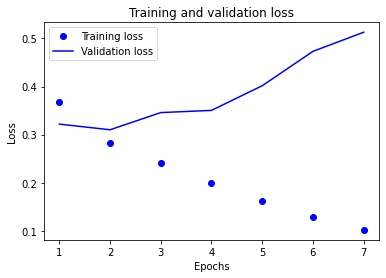

In [27]:
LSTM_model_dict = LSTM_model.history

acc = LSTM_model_dict['accuracy']
val_acc = LSTM_model_dict['val_accuracy']
loss = LSTM_model_dict['loss']
val_loss = LSTM_model_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

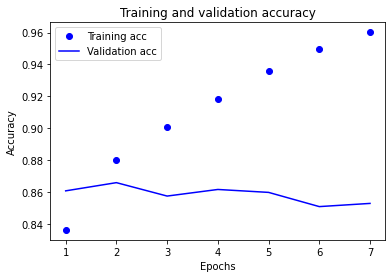

In [28]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Since the accuracy is over 0.85... I will skip the embdding layer and continue to the next model!

## 3) GlobalMaxPooling
### Train the Model


In [30]:
vocab_size = 10000
word_vector_dim = 64

GMP_model = keras.Sequential()
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))

GMP_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 640,529
Trainable params: 640,529
Non-trainable params: 0
_________________________________________________________________


In [32]:
GMP_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

GMP_history = GMP_model.fit(partial_x_train,
                    partial_y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
3631/3631 [==============================] - 39s 11ms/step - loss: 0.3903 - accuracy: 0.8272 - val_loss: 0.3416 - val_accuracy: 0.8514
Epoch 2/10
3631/3631 [==============================] - 37s 10ms/step - loss: 0.3029 - accuracy: 0.8727 - val_loss: 0.3389 - val_accuracy: 0.8554
Epoch 3/10
3631/3631 [==============================] - 37s 10ms/step - loss: 0.2603 - accuracy: 0.8942 - val_loss: 0.3489 - val_accuracy: 0.8548
Epoch 4/10
3631/3631 [==============================] - 37s 10ms/step - loss: 0.2231 - accuracy: 0.9117 - val_loss: 0.3722 - val_accuracy: 0.8517
Epoch 5/10
3631/3631 [==============================] - 36s 10ms/step - loss: 0.1897 - accuracy: 0.9271 - val_loss: 0.3980 - val_accuracy: 0.8469
Epoch 6/10
3631/3631 [==============================] - 36s 10ms/step - loss: 0.1599 - accuracy: 0.9399 - val_loss: 0.4411 - val_accuracy: 0.8475
Epoch 7/10
3631/3631 [==============================] - 37s 10ms/step - loss: 0.1345 - accuracy: 0.9501 - val_loss: 0.4886 -

In [33]:
results = GMP_model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6731 - accuracy: 0.8265
[0.6731432676315308, 0.8264540433883667]


### Visualization


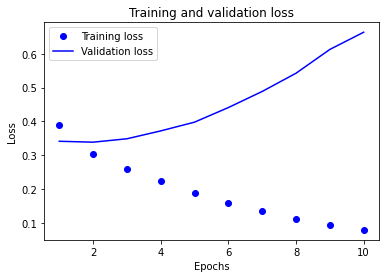

In [34]:
GMP_history_dict = GMP_history.history

acc = GMP_history_dict['accuracy']
val_acc = GMP_history_dict['val_accuracy']
loss = GMP_history_dict['loss']
val_loss = GMP_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

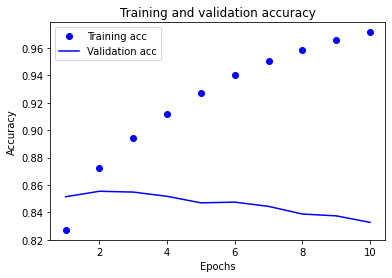

In [35]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Okay, the result is not good: 0.82   
I will also skip embedding for this, since I got reasonable result from 1d CNN (with Korean word2Vec embedding layer) and LSTM without embedding layer.

# Conclusion
## Things I've learned
- Visualization of loss and accuracy.
- Analyze the trained embedding layer, Word2Vec.
- Utilize pre-trained Korean Word2Vec Embedding to improve the model.
- LSTM
- LayerNormLSTM
- GlobalMaxPooling

## Challenges I've Faced
- From the result, I noticed that LSTM returns the most highest accuracy 0.8516.
- I also tried 1D CNN with Korean Word2Vec Embedding layer, but the highest accuracy was 0.84

